In [1]:
import pandas as pd
#data collection
df = pd.read_csv('dataset_phishing.csv')

df.head()

#data pre-processing 
if 'url' in df.columns:
    df.drop(columns='url',inplace=True)

df['status'] = df['status'].map({'phishing':1, 'legitimate':0})

df_clean = df.dropna()

df_clean.to_csv("phishing_data.csv",index=False)

df_clean.head()


,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,0
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,1
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,1
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,0
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,0


In [2]:
#Train-test split
from sklearn.model_selection import train_test_split

phish = pd.read_csv('phishing_data.csv')

X = phish.drop(columns=['status'])
Y = phish['status']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"X_train shape:{X_train.shape}, X_test shape:{X_test.shape}, Y_train shape:{Y_train.shape}, Y_test shape:{Y_test.shape}")

X_train shape:(9144, 87), X_test shape:(2286, 87), Y_train shape:(9144,), Y_test shape:(2286,)


In [3]:
#Support vector classifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train,Y_train)

svm_pred = svm_clf.predict(X_test)

#Accuracy Worst
print("SVM Accuracy:", accuracy_score(Y_test, svm_pred) * 100)
print("Confusion Matrix:\n", confusion_matrix(Y_test, svm_pred))
print("Classification Report:\n", classification_report(Y_test, svm_pred))

print("Prediction: ",svm_pred)

SVM Accuracy: 59.580052493438316
Confusion Matrix:
 [[364 793]
 [131 998]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.31      0.44      1157
           1       0.56      0.88      0.68      1129

    accuracy                           0.60      2286
   macro avg       0.65      0.60      0.56      2286
weighted avg       0.65      0.60      0.56      2286

Prediction:  [0 1 1 ... 1 1 1]


In [4]:
#Random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rfc_clf = RandomForestClassifier(random_state=42)
rfc_clf.fit(X_train,Y_train)

rfc_pred = rfc_clf.predict(X_test)

#Accuracy Best
print("Random Forest Accuracy:", accuracy_score(Y_test, rfc_pred) * 100)
print("Confusion Matrix:\n", confusion_matrix(Y_test, rfc_pred))
print("Classification Report:\n", classification_report(Y_test, rfc_pred))

print("Prediction: ",rfc_pred)

Random Forest Accuracy: 96.93788276465442
Confusion Matrix:
 [[1129   28]
 [  42 1087]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1157
           1       0.97      0.96      0.97      1129

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286

Prediction:  [0 0 0 ... 1 0 1]


In [5]:
#Voting Classifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

ens_clf = VotingClassifier(estimators=[('SVM',svm_clf),('RFC',rfc_clf)], voting='hard')
ens_clf.fit(X_train, Y_train)

ens_pred = ens_clf.predict(X_test)

#Accuracy Average
print("Ensemble Model Accuracy:", accuracy_score(Y_test, ens_pred) * 100)
print("Confusion Matrix:\n", confusion_matrix(Y_test, ens_pred))
print("Classification Report:\n", classification_report(Y_test, ens_pred))

print("Prediction: ",ens_pred)

Ensemble Model Accuracy: 92.34470691163604
Confusion Matrix:
 [[1133   24]
 [ 151  978]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93      1157
           1       0.98      0.87      0.92      1129

    accuracy                           0.92      2286
   macro avg       0.93      0.92      0.92      2286
weighted avg       0.93      0.92      0.92      2286

Prediction:  [0 0 0 ... 1 0 1]


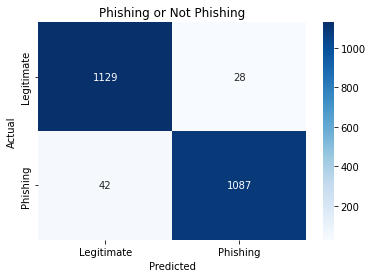

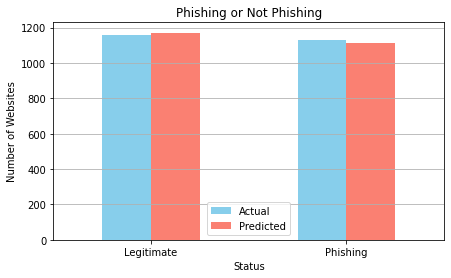

In [16]:
#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

#Heatmap
y_pred = rfc_clf.predict(X_test)

cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Phishing or Not Phishing')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#BarGraph
actual_counts = pd.Series(Y_test).value_counts().sort_index()
predicted_counts = pd.Series(y_pred).value_counts().sort_index()

comparison_df = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': predicted_counts
})
comparison_df.index = ['Legitimate', 'Phishing']

comparison_df.plot(kind='bar', figsize=(7, 4), color=['skyblue', 'salmon'])
plt.title('Phishing or Not Phishing')
plt.ylabel('Number of Websites')
plt.xlabel('Status')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

The project does not involve the use of regression models, as it focuses on classification—determining whether a website is phishing or legitimate—rather than predicting continuous outcomes. Since the model cannot directly process raw URLs, feature extraction was already performed in the dataset itself. As the emphasis is on detection rather than prediction, there was no need for real-time URL processing. Among the three classification models tested, the Random Forest Classifier achieved the best performance metrics and was therefore selected for visualization and further analysis.